# Deep Learning for Text

In [1]:
import sys
import os

import pandas as pd

# FOLDERS
package_path = os.path.dirname(os.getcwd())
data_path = os.path.join(package_path, 'data')
experiments_path = os.path.join(package_path, 'experiments')

# LOAD DATA
input_file = os.path.join(data_path, 'train.json')

df = pd.read_json(input_file)
df.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


The `ingredients` entries in the dataframe are lists and within each **list** entry has an individual ingredient of a particular recipe. To make the tokenization process easier we will need to convert each recipe into a **string** object, so let's create a new column for the dataframe called `ingredients_str`.

In [2]:
df['ingredients_str'] = [', '.join(i).strip() for i in df['ingredients']] 

df['ingredients_str'].head()

0    romaine lettuce, black olives, grape tomatoes,...
1    plain flour, ground pepper, salt, tomatoes, gr...
2    eggs, pepper, salt, mayonaise, cooking oil, gr...
3                    water, vegetable oil, wheat, salt
4    black pepper, shallots, cornflour, cayenne pep...
Name: ingredients_str, dtype: object

Now each recipe is a **string** with the ingredients separated by commas. Now it should be easier to proceed with the tokenization process.

## Using *Keras* for word level representations.

The `Keras` library has a class to deal with the tokenization of text documents. Next, we are going to use the `Tokenizer` class to create **word level representations**:

Note that for this problem the expression **word level representationg** does not mean that we re going to tokenize each word separately. What we are goint to do is to tokenize each ingredient inside a particular recipe, even if it has more than one word. The example bellow could be used to clarify.

**Task:** Tokenize the following recipe: *ground black pepper, cold water*

* ['ground', 'black', 'pepper', 'cold', 'water]

But for this problem we will tokenize the recipe in the following way:

* ['ground black pepper', 'cold water']

In [3]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [4]:
# creates a Tokenizer object using all the words in the vocabulary
tokenizer = Tokenizer(num_words=6000, split=', ', lower=True)

# builds the word index
tokenizer.fit_on_texts(df['ingredients'])

# recover the word index
word_index = tokenizer.word_index

# turn strings into lists of integer indices
sequences = tokenizer.texts_to_sequences(df['ingredients'])

In [5]:
for key in list(word_index.keys())[:5]:
    print('word_index[%s] = %s' % (key, word_index[key]))

word_index[salt] = 1
word_index[onions] = 2
word_index[olive oil] = 3
word_index[water] = 4
word_index[garlic] = 5


As we can see above, the `word_index` is a dictionary with a integer index for each word/ingredient present in the dataset. The words/ingredients are automatically organized by the most common

### TF-IDF Representation

Let's build our model based on the **TF-IDF** representation for text data.

In [6]:
# directly get the representations
tfidf_data = tokenizer.texts_to_matrix(df['ingredients'], mode='tfidf')

In [7]:
n_samples = tfidf_data.shape[0]
n_features = tfidf_data.shape[1]

print('The training dataset with the new representation have:')
print('  - %i entries/recipes' % n_samples)
print('  - %i features/ingredients' % n_features)

The training dataset with the new representation have:
  - 39774 entries/recipes
  - 6000 features/ingredients


## Create Cross Validation Partitions

As we know from the **EDA notebook** of this dataset, the labels are unbalanced. So, we are going to use the `StratifiedKFold` class, from the **Sklearn** library to help us to create folds which are made by preserving the percentage of entries for each label.

In [8]:
# construct the target vector
import numpy as np
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

# categorical target (one-hot encoded)
lb = LabelBinarizer()
target_cat = lb.fit_transform(df['cuisine']) 

# integer target, used in the StratifiedKfold class 
# in order to make each fold with balanced classes
le = LabelEncoder()
target = le.fit_transform(df['cuisine']) 

n_classes = len(np.unique(target))
print('The dataset has %i unique classes.' % n_classes)

The dataset has 20 unique classes.


In [9]:
from sklearn.model_selection import StratifiedKFold

n_splits = 5
seed = 2018
folds = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed).split(tfidf_data, target))

for i, fold in enumerate(folds):
    percentage_trn = (len(fold[0]) / n_samples) * 100
    percentage_val = (len(fold[1]) / n_samples) * 100
    print('Fold #%i has %1.0f%% events for training and %1.0f%% for validation.' % (i+1, percentage_trn, percentage_val))

Fold #1 has 80% events for training and 20% for validation.
Fold #2 has 80% events for training and 20% for validation.
Fold #3 has 80% events for training and 20% for validation.
Fold #4 has 80% events for training and 20% for validation.
Fold #5 has 80% events for training and 20% for validation.


We can see that the percentage of events in training and validation sets are the same for every fold.

## Create a Model

Now it's time to create a Deep Neural Network Model to train our dataset. The model architecture can be inferred from the code below.

In [10]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
import keras.backend as K

In [11]:
def load_model():
    """
    Function to create the Neural Network Model
    """
    K.clear_session()
    
    # creating the Deep Neural Net Model
    model = Sequential()

    # layer 1
    model.add(Dense(units=128, 
                    activation='relu', 
                    input_shape=(tfidf_data.shape[1], )))
    model.add(BatchNormalization())
    model.add(Dropout(0.7))

    # layer 2
    model.add(Dense(units=64, 
                    activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.7))

    # output layer
    model.add(Dense(units=n_classes,
                    activation='softmax'))

    # compile model
    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(lr=0.005), 
                  metrics=['acc'])
    
    return model

Add the `EarlyStop` callback to monitor the validation loss and avoid overfitting. 

In [12]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# add callbacks to the model
early_stop = EarlyStopping(monitor='val_loss', patience=3)

weights_file = os.path.join(experiments_path, 'deeep_model.hdf5')
checkpoint = ModelCheckpoint(weights_file, monitor='val_loss', save_best_only=True)

callbacks = [early_stop, checkpoint]

In [13]:
cv_scores = []
cv_hist = []

# train the model
for fold, (trn_idx, val_idx) in enumerate(folds):
    print('>> Fold %i# <<' % int(fold+1))
    
    # get training and validation data folds
    X_trn = tfidf_data[trn_idx, :]
    y_trn = target_cat[trn_idx, :]
    X_val = tfidf_data[val_idx, :]
    y_val = target_cat[val_idx, :]
    
    print('  Training on %i examples.' % X_trn.shape[0])
    print('  Validating on %i examples.' % X_val.shape[0])
    
    model = load_model()
    
    # serialize model to JSON
    if fold == 0:
        model_json = model.to_json()
        model_file = os.path.join(experiments_path, 'deep_model.json')
        with open(model_file, 'w') as json_file:
            json_file.write(model_json)
    
    hist = model.fit(X_trn, y_trn, 
                     validation_data=(X_val, y_val), 
                     batch_size=32, 
                     epochs=100, 
                     callbacks=callbacks,
                     verbose=0)
    
    
    scores = model.evaluate(X_val, y_val)
    print('  This model has %1.2f validation accuraccy.\n' % scores[1])
    
    cv_scores.append(scores)
    cv_hist.append(hist)

>> Fold 1# <<
  Training on 31812 examples.
  Validating on 7962 examples.
7962/7962 [==============================] - 1s 68us/step
  This model has 0.76 validation accuraccy.

>> Fold 2# <<
  Training on 31816 examples.
  Validating on 7958 examples.
7958/7958 [==============================] - 1s 87us/step
  This model has 0.77 validation accuraccy.

>> Fold 3# <<
  Training on 31818 examples.
  Validating on 7956 examples.
7956/7956 [==============================] - 1s 93us/step
  This model has 0.77 validation accuraccy.

>> Fold 4# <<
  Training on 31823 examples.
  Validating on 7951 examples.
7951/7951 [==============================] - 1s 76us/step
  This model has 0.77 validation accuraccy.

>> Fold 5# <<
  Training on 31827 examples.
  Validating on 7947 examples.
7947/7947 [==============================] - 1s 76us/step
  This model has 0.77 validation accuraccy.



In [14]:
val_acc = []

for metric in cv_scores:
    val_acc.append(metric[1])
    
print('Accuracy = %1.4f +- %1.4f' % (np.mean(val_acc), np.std(val_acc)))

Accuracy = 0.7686 +- 0.0032


## Getting the Best Model

Now let's get the best trained model and make some plots.

In [15]:
model.load_weights(weights_file)

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

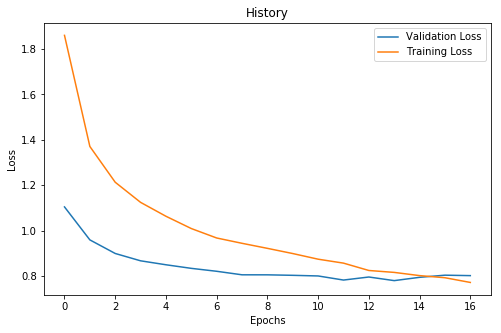

In [17]:
fig = plt.figure(figsize=(8,5))
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.plot(model.history.history['loss'], label='Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('History')
plt.legend()
plt.show()

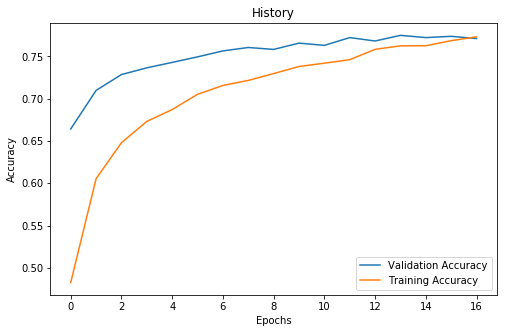

In [18]:
fig = plt.figure(figsize=(8,5))
plt.plot(model.history.history['val_acc'], label='Validation Accuracy')
plt.plot(model.history.history['acc'], label='Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('History')
plt.legend()
plt.show()

## Making Submission File

In [19]:
input_file = os.path.join(data_path, 'test.json')

df = pd.read_json(input_file)

In [20]:
# directly get the representations
tfidf_data = tokenizer.texts_to_matrix(df['ingredients'], mode='tfidf')

n_samples = tfidf_data.shape[0]
n_features = tfidf_data.shape[1]

print('The test dataset with the new representation have:')
print('  - %i entries/recipes' % n_samples)
print('  - %i features/ingredients' % n_features)

The test dataset with the new representation have:
  - 9944 entries/recipes
  - 6000 features/ingredients


In [21]:
# predict classes using test data
predict = model.predict_classes(tfidf_data)

# map each integer to the string labels
cat = pd.factorize(le.classes_)

# create the column
df['cuisine'] = cat[1][predict]

In [22]:
submissions_path = os.path.join(package_path, 'submissions')
submissions_file = os.path.join(submissions_path, 'deep_model.csv')

In [23]:
df[['id', 'cuisine']].to_csv(submissions_file, index=False)